# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model. 

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business. 

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:** 
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions. 

**Note:** This notebook uses the `surprise` library for building recommendation systems. Install it using:
```bash
pip install scikit-surprise
```

The dataset is located in the `data/` folder of this project directory.

Installing surprise library 


In [1]:
# Install scikit-surprise
# For Windows users, if you encounter build errors, try:
# Option 1: Install using conda (recommended for Windows)
#   conda install -c conda-forge scikit-surprise
# Option 2: Install Microsoft C++ Build Tools from:
#   https://visualstudio.microsoft.com/visual-cpp-build-tools/
# Option 3: Use pre-built wheel (if available for your Python version)
#   pip install scikit-surprise --only-binary :all:

%pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


## **Importing the necessary libraries and overview of the dataset**

In [2]:
import warnings                                 # Used to ignore the warning given as output of the code
warnings.filterwarnings('ignore')

import numpy as np                              # Basic libraries of python for numeric and dataframe computations
import pandas as pd

import matplotlib.pyplot as plt                 # Basic library for data visualization
import seaborn as sns                           # Slightly advanced library for data visualization

from collections import defaultdict             # A dictionary output that does not raise a key error

from sklearn.metrics import mean_squared_error  # A performance metrics in sklearn

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [3]:
# Import the Dataset (no headers in the CSV file)
df = pd.read_csv('data/ratings_Electronics.csv', header=None)

# Add column names
df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

# Drop the column timestamp
df = df.drop('timestamp', axis=1)

df_copy = df.copy(deep = True) # Copying the data to another DataFrame



**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product. 

In [4]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:        
        ratings_count[user] += 1
  
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [5]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [6]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:
    
    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1
    
    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1    

In [7]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [8]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [9]:
# Check the number of rows and columns and provide observations
shape = df_final.shape
print("Number of rows:", shape[0])
print("Number of columns:", shape[1])

Number of rows: 65290
Number of columns: 3


Observation: There are 65290 rows and 3 columns in the data.



### **Data types**

In [10]:
# Check Data types and provide observations
df_final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


Observation: There are no null values present in dataframe. Rating is the only numerical column based on dtypes given above.

### **Checking for missing values**

In [11]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

Observation: All the attributes have 0 null values.



### **Summary Statistics**

In [12]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T


,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


Observation: The rating is the only numerical column to have the summary statistics. All the 50% 75% and max are given the rating of 5.0 Range is max - min = 4.0. IQR: 1.0. The mean is less than the median. The summary suggests that the ratings are positively skewed since the mean is less than the median, and a substantial number of ratings are at the maximum possible value.

### **Checking the rating distribution**

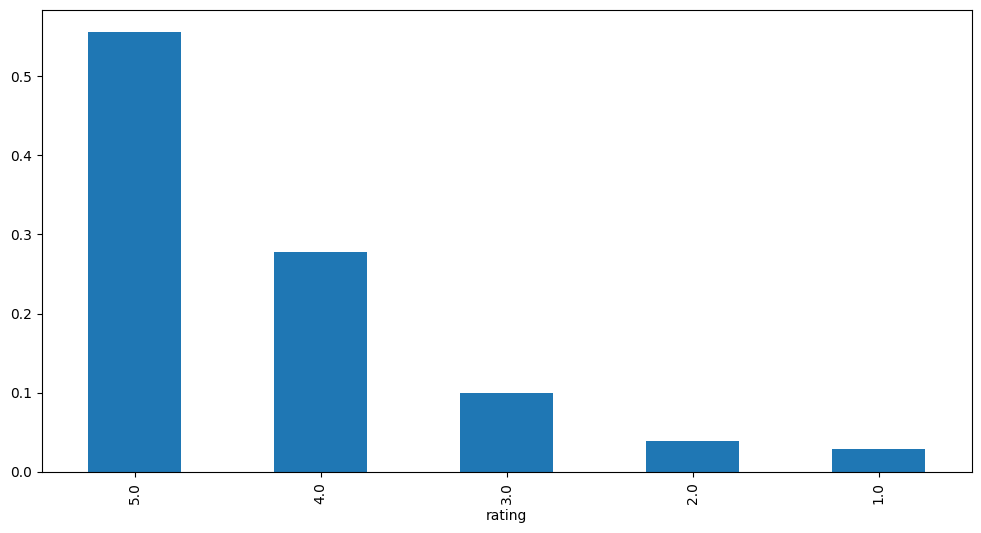

In [13]:
# Create the bar plot and provide observations
plt.figure(figsize = (12, 6))

df_final['rating'].value_counts(1).plot(kind = 'bar')

plt.show()

Observation: The highest bar is for rating of 5.0, which suggests that it is the most common rating given. Its relative frequency exceeds 0.5, which implies that more than half of the ratings in the dataset are 5.0. There is a positive skew in the data, meaning there is a higher concentration of higher ratings. Counts have been normalized to show proportions rather than absolute counts by the command value_counts(1). Ratings 3 to 1 are the least occuring, suggesting that people give ratings for products they really like.

### **Checking the number of unique users and items in the dataset**

In [14]:
# Number of total rows in the data and number of unique user id and product id in the data
print('The number of observations in the final data = ', len(df_final))
print('Number of unique USERS in Raw data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df_final['prod_id'].nunique())

The number of observations in the final data =  65290
Number of unique USERS in Raw data =  1540
Number of unique ITEMS in Raw data =  5689


Observation: There are 1540 unique users in the dataset. There are 5689 unique products in the dataset. As per the number of unique users and products, there is a possibility of 1540 * 5689 = 8,761,060 ratings in the dataset. But we only have 7,824,482 ratings, i.e., not every user has rated every product in the dataset. And we can build a recommendation system to recommend a product to users. Since the raw dataset was very large we are using the df_final dataset to build the model.

### **Users with the most number of ratings**

In [15]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

Observation: The highest number of ratings by a user is 295 which is far from the actual number of products present in the data. We can build a recommendation system to recommend products to users which they have not interacted with. But still, there is a possibility of 5689 - 295 = 5394 more interactions as we have 5689 unique products in our dataset. For those remaining products, we can build a recommendation system to predict which product is likely to be rated by this user.

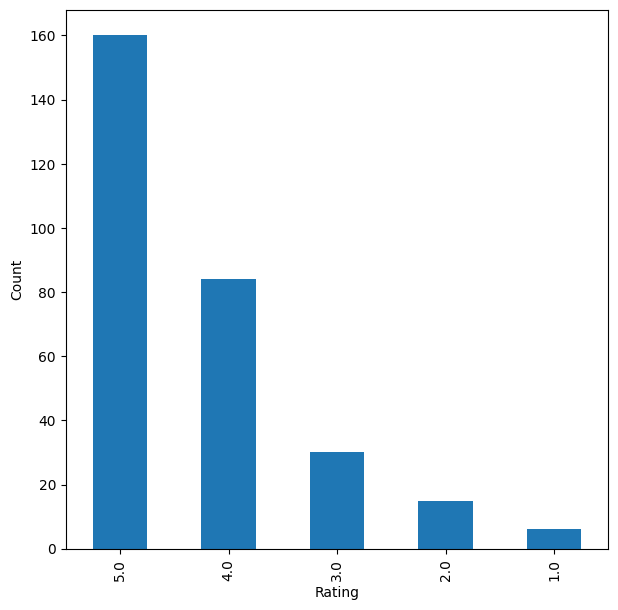

In [16]:
# Plotting distributions of ratings for 295 interactions with given user_id
plt.figure(figsize = (7, 7))

df_final[df_final['user_id'] == "ADLVFFE4VBT8"]['rating'].value_counts().plot(kind = 'bar')

# Name the xlabel of the plot
plt.xlabel('Rating')

# Name the ylabel of the plot
plt.ylabel('Count')

# Display the plot
plt.show()

In [17]:
most_rated_products = df_final.groupby('prod_id').size().sort_values(ascending = False)[:10]
most_rated_products

prod_id
B0088CJT4U    206
B003ES5ZUU    184
B000N99BBC    167
B007WTAJTO    164
B00829TIEK    149
B00829THK0    137
B008DWCRQW    137
B002R5AM7C    128
B004CLYEDC    118
B002SZEOLG    113
dtype: int64

Observation:

The product with prod_id B0088CJT4U has been interacted with by most users which is 206 times.
But still, there is a possibility of 1540-206 = 1334 more interactions as we have 1540 unique users in our dataset. For those remaining users, we can build a recommendation system to predict who is most likely to buy this product.
Also, out of these 206 interactions, we need to consider the distribution of ratings as well to check whether this product is the most liked or most disliked

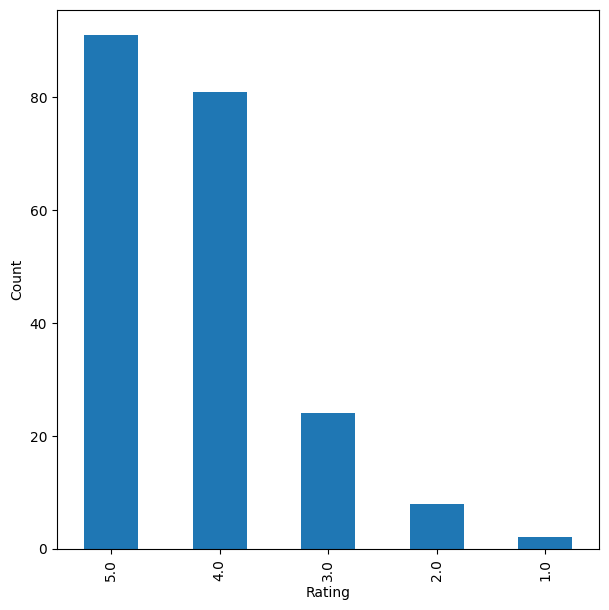

In [18]:
# Plotting distributions of ratings for 295 interactions with given user_id
plt.figure(figsize = (7, 7))

df_final[df_final['prod_id'] == "B0088CJT4U"]['rating'].value_counts().plot(kind = 'bar')

# Name the xlabel of the plot
plt.xlabel('Rating')

# Name the ylabel of the plot
plt.ylabel('Count')

# Display the plot
plt.show()

Observation: The product is liked by majority of the users.



**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [19]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating': avg_rating, 'rating_count': count_rating})
# Sort the dataframe by average of ratings in the descending order
final_rating = final_rating.sort_values(by='avg_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [20]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    # Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] >= min_interaction]

    # Sorting values with respect to average rating in descending order
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.head(n).index

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [21]:
list(top_n_products(final_rating, 5, 50))


['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [22]:
list(top_n_products(final_rating, 5, 100))


['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [23]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them. 

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [24]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)
    
    # Making predictions on the test data
    predictions = model.test(testset)
    
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    
    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    
    accuracy.rmse(predictions)
    
    print('Precision: ', precision) # Command to print the overall precision
    
    print('Recall: ', recall) # Command to print the overall recall
    
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [25]:
df_final.head()


,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


In [26]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)


Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [27]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': True  # user-user similarity
}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


Observation: An RMSE of 1.0012 suggests that the average prediction error is slightly over 20% of the full range of possible ratings (5 - 0 = 5). The RMSE value suggests that on average, the predicted ratings are about 1 point away from the actual ratings. Precision of 0.855 suggests that 85.5% of the items the system recommends are actually liked by the users. Out of all the recommended products 85.5% are relevant. The recall of 0.858 indicates that the system successfully retrieves a high proportion of the items that users are interested in. Out of all the relevant products, 85.8% are recommended. The F_1 score which is the harmonic mean of precision and recall, is 0.856. This suggests a system with both high precision and high recall. An F_1 score closer to 1 is indicative of a robust model. The model recommends items to a user based on the preferences of similar users. Cosine similarity is useful when you're more interested in the orientation (i.e., which items users like, regardless of the number of items rated) rather than the magnitude of ratings. Random_state=1 ensures that the results are reproducible.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [28]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

Observation: : The actual rating provided by the user (r_ui) for the item is 5.0, the highest possible rating. The estimated rating (est) predicted is 3.4. Given the discrepancy between the estimated and actual ratings, the recommendation algorithm may need further tuning or additional information to improve its predictions. This might involve incorporating more user data, refining the model, or considering different algorithms or parameters. The model is underestimating the ratings.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [29]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != "1400501466"].user_id.unique()


array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A34BZM6S9L7QI4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.** 

In [30]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

Observation: The system estimated a rating of 4.29 for this user-product pair. The details dictionary in the output contains the key was_impossible set to True, which signifies that a reliable prediction could not be made. The algorithm could not find a sufficient number of similar users to make a reliable prediction. Despite being marked as impossible, the system still provides an estimated rating which could be based on the global average, user average, item average, or some other default strategy when the user-item interaction data is not sufficient.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [31]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],  # number of neighbors
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],  # similarity measures to test
        'user_based': [True, False]  # user-based or item-based collaborative filtering
    }
}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)
# Best RMSE score
print('Best RMSE score: ', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best parameters: ', gs.best_params['rmse'])

Best RMSE score:  1.0345478608084877
Best parameters:  {'k': 30, 'sim_options': {'name': 'pearson', 'user_based': False}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [32]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {
    'name': 'msd',  # or 'cosine' or 'pearson', depending on your results
    'user_based': True  # since we are doing user-user CF
}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=20, min_k=5, random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized, k=10)


RMSE: 0.9523
Precision:  0.849
Recall:  0.892
F_1 score:  0.87


Observation: The F_1 score has increased from 0.856 to 0.87. RMSE is reduced from 1.0012 to 0.95. Precision has decreased while Recall has increased.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [33]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
prediction_A3 = sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466")
print("Predicted rating for user A3LDPF5FMB782Z on product 1400501466:", prediction_A3.est)


Predicted rating for user A3LDPF5FMB782Z on product 1400501466: 4.849056603773586


In [34]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction_A34 = sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466")
print("Predicted rating for user A34BZM6S9L7QI4 on product 1400501466:", prediction_A34.est)

Predicted rating for user A34BZM6S9L7QI4 on product 1400501466: 4.292024046561495


Observation: The latter user is likely to give a lower rating to the product compared to the former. But the prediction of the latter user when compared to the baseline model remains the same, while the former user's prediction is increased from 3.4 to 4.849

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [35]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)


[6, 42, 44, 54, 66]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [36]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended product ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    
    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        
        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [37]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user_optimized)


In [38]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])


,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001ENW61I,5
3,B001TH7GUU,5
4,B001TH7T2U,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**. 

In [39]:
# Declaring the similarity options
sim_options = {
    'name': 'cosine',
    'user_based': False  # False indicates item-item CF
}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item, k=10)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


Observation: Item-Item Similarity: The recommendation system has been setup to calculate similarities between items (products), rather than between users. This is indicated by the user_based: False setting in the sim_options dictionary.The cosine similarity measure is used to calculate the similarity between items. The system uses a k-nearest neighbors algorithm (KNNBasic) for finding similar items. The random_state=1 parameter ensures reproducibility of results; k=10, which means that the top 10 recommendations for each user are considered.

RMSE of the predictions is 0.9950, indicating that on average, the model's predicted ratings are about one point off from the actual ratings, which is a moderate error given the 0-5 rating scale. -Precision is 0.838, suggesting that 83.8% of the top 10 items recommended by the system are relevant to the users.
Recall is 0.845, indicating that the system is able to identify 84.5% of the relevant items within the top 10 recommendations.
The F_1 score, which is the harmonic mean of precision and recall, is 0.841, showing a good balance between precision and recall.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [40]:
# Predicting rating for a sample user with an interacted product
predicted_rating = sim_item_item.predict("A3LDPF5FMB782Z", "1400501466")
print("Estimated Rating:", predicted_rating.est)

Estimated Rating: 4.2727272727272725


Observation: The system expects the user to have a positive preference for this product, given that the rating is closer to the upper end of the rating scale (assuming a 0-5 scale). However this is lower than the rating predicted by the user-user similarity tuned model

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [41]:
# Predicting rating for a sample user with a non interacted product
predicted_rating = sim_item_item.predict("A34BZM6S9L7QI4", "1400501466")
print("Estimated Rating:", predicted_rating.est)

Estimated Rating: 4.292024046561495


Observation: This rating is similar to the one predicted in the earlier user-user model. And this user is likely to rate this product more than the previous user in this case.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters 

In [42]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k': [10, 20, 30],
    'min_k': [3, 6, 9],
    'sim_options': {
        'name': ['msd', 'cosine'],
        'user_based': [False]  # Ensure it's item-item CF
    }
}

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print('Best RMSE score:', gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print('Best parameters:', gs.best_params['rmse'])

Best RMSE score: 0.9751752425616571
Best parameters: {'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [43]:
# Using the optimal similarity measure for item-item based collaborative filtering
best_params = gs.best_params['rmse']
sim_options = {
    'name': best_params['sim_options']['name'],
    'user_based': best_params['sim_options']['user_based']  # should be False for item-item CF
}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options=sim_options, k=best_params['k'], min_k=best_params['min_k'], random_state=1, verbose=False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)


# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9578
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


Observation: Compared to the previous statistic: RMSE: 0.9950 Precision: 0.838 Recall: 0.845 F_1 score: 0.841

The RMSE here is lesser than before. Recall is higher than 0.845 which was the predicted value in the last algorithm. model.F_1 score is greater than the score in the previous algorithm which was 0.841

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [44]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
optimized_prediction_A3 = sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466")
print("Optimized model predicted rating for A3LDPF5FMB782Z on product 1400501466:", optimized_prediction_A3.est)


Optimized model predicted rating for A3LDPF5FMB782Z on product 1400501466: 4.7105263157894735


In [45]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
optimized_prediction_A34 = sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466")
print("Optimized model predicted rating for A34BZM6S9L7QI4 on product 1400501466:", optimized_prediction_A34.est)


Optimized model predicted rating for A34BZM6S9L7QI4 on product 1400501466: 4.292024046561495


Observation: For the first user, the prediction is on the upper end. The second user has the same prediction as in the earlier model based on user-user similarity, and in the untuned model 2 algorithm.



### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [46]:
sim_item_item_optimized.get_neighbors(0, k=5)


[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [47]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)


In [48]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ['prod_id', 'predicted_ratings'])


,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [49]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


Observations:

The RMSE is reduced (0.882). This is the least of both the models earlier indicating a better fit. The random_state=1 parameter ensures that the results are reproducible by initializing the random number generator to a fixed state.
Here, precision is 0.853, which means that 85.3% of the items recommended by the model are relevant to the users.
Recall measures the ratio of relevant items that are recommended. A recall of 0.88 indicates that the model recommends 88% of the items that are relevant to the users.
The F_1 score here is 0.866, suggesting a good balance between precision and recall.

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [50]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)


user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

Observation: Compared to model 2 this predicted value is lower and over 3.5 which still indicates a likelihood of positive preference. The prediction here is higher than model 1. The was_impossible is False which means the prediction is feasible.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [51]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)


user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

Observations: The was_impossible is false so a prediction is feasible. The highest compared to both user-user and item-item based similarity. 4.4 is on the upper end of user preference

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [52]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print('Best RMSE score:', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best parameters:', gs.best_params['rmse'])

Best RMSE score: 0.8978330655617626
Best parameters: {'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [53]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
best_params = gs.best_params['rmse']
optimized_svd = SVD(n_epochs=best_params['n_epochs'], lr_all=best_params['lr_all'],
                    reg_all=best_params['reg_all'], random_state=1)

# Train the algorithm on the trainset
optimized_svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(optimized_svd)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


Observations: Compared to the previous svd algorithm (model 3) - untuned - the RMSE is lower which is a good sign. The precision is higher than 0.853 which is also a good sign. F1_score has remained the same for both. Recall has decreased however by 0.002.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [54]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
prediction_A3 = optimized_svd.predict("A3LDPF5FMB782Z", "1400501466")
print("Predicted rating for A3LDPF5FMB782Z on product 1400501466:", prediction_A3.est)

Predicted rating for A3LDPF5FMB782Z on product 1400501466: 4.128589011282042


In [55]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
prediction_A34 = optimized_svd.predict("A34BZM6S9L7QI4", "1400501466")
print("Predicted rating for A34BZM6S9L7QI4 on product 1400501466:", prediction_A34.est)

Predicted rating for A34BZM6S9L7QI4 on product 1400501466: 4.216280997100113


Observation: The prediction of the first user here is greater than the baseline model. The prediction of the second user is lower than the baseline model.

### **Conclusion and Recommendations**

In this case study, we built recommendation systems using the following different algorithms.

Rank-based using averages

User-user-similarity-based collaborative filtering

Item-item-similarity-based collaborative filtering

Model-based (matrix factorization) collaborative filtering

We have seen how they are different from each other and what kind of data is needed to build each of these recommendation systems. We can further combine all the recommendation techniques we have seen.

To demonstrate "user-user-similarity-based collaborative filtering","item-item-similarity-based collaborative filtering", and "model-based (matrix factorization) collaborative filtering", surprise library has been introduced. For these algorithms grid search cross-validation is applied to find the best working model, and using that the corresponding predictions are done.

For performance evaluation of these models precision@k and recall@k are introduced in this case study. Using these two metrics F_1 score is calculated for each working model.

High precision means that an algorithm returned substantially more relevant results than irrelevant ones, with few false positives. If you raise the threshold for classifying a positive case, you’ll typically increase precision but might decrease recall. Precision is impacted when there is a change in the number of false positives. If false positives increase, precision decreases.

High recall means that an algorithm returned most of the relevant results, with few false negatives. If you lower the threshold for classifying a positive case, you’ll typically increase recall but might also increase the false positives, thus lowering precision. Recall is impacted when there is a change in the number of false negatives. If false negatives increase, recall decreases.

Hence all in all, following are the obtained prediction statistics for each model:

RMSE: 1.0012 Precision: 0.855 Recall: 0.858 F_1 score: 0.856

RMSE: 0.9523 Precision: 0.849 Recall: 0.892 F_1 score: 0.87

RMSE: 0.9950 Precision: 0.838 Recall: 0.845 F_1 score: 0.841

RMSE: 0.9578 Precision: 0.839 Recall: 0.88 F_1 score: 0.859

RMSE: 0.8882 Precision: 0.853 Recall: 0.88 F_1 score: 0.866

RMSE: 0.8808 Precision: 0.854 Recall: 0.878 F_1 score: 0.866

Recommendation: Model 3 with tuned values and RMSE 0.8808 has the lowest RMSE, which is good. The same model with RMSE 0.8808 also has high precision (0.854), recall (0.878), and F_1 score (0.866).This model has a good balance between all four metrics, making it the most optimal among others. It has the lowest error and still maintains high precision, recall, and F_1 score, which means it's accurate and reliable in its recommendations.